
# Adversarial Attack Evaluation on Celebrity Faces (FGSM, PGD, Noise)



In [ ]:

!pip install facenet-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124

In [ ]:
# Import Database
!pip install "deeplake<4.0.0"

import deeplake
ds = deeplake.load('hub://activeloop/lfw-deep-funneled')
print(ds)


/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lfw-deep-funneled



\

hub://activeloop/lfw-deep-funneled loaded successfully.

Dataset(path='hub://activeloop/lfw-deep-funneled', read_only=True, tensors=['images', 'name'])


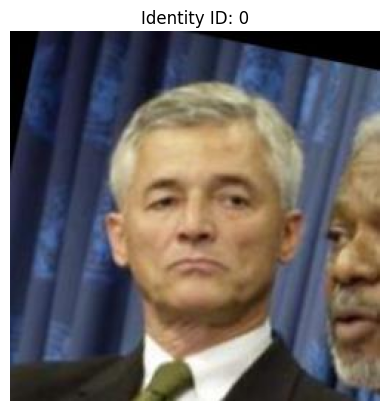

In [ ]:
# Example Image
import matplotlib.pyplot as plt

sample = next(iter(ds))
img = sample.images.numpy()
label = sample.name.numpy()[0]

plt.imshow(img)
plt.axis('off')
plt.title(f"Identity ID: {label}")
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from scipy.spatial.distance import cosine

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device)
mtcnn = MTCNN(image_size=160, margin=20, device=device)
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
target_layer = model.block8

def get_face_tensor(img_array):
    img_pil = Image.fromarray(img_array.astype('uint8')).convert('RGB')
    face = mtcnn(img_pil)
    if face is not None:
        return face.to(device)
    return None

def embeddings(face_tensor):
    with torch.no_grad():
        return model(face_tensor.unsqueeze(0)).squeeze().cpu().numpy()

def cosine_similarity(emb1, emb2):
    return 1 - cosine(emb1, emb2)

def gradcam(model, face_tensor, target_layer):
    gradients, activations = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    h_f = target_layer.register_forward_hook(forward_hook)
    h_b = target_layer.register_backward_hook(backward_hook)
    face_tensor = face_tensor.unsqueeze(0).requires_grad_()
    output = model(face_tensor)
    output.mean().backward()
    weights = gradients[0].mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations[0]).sum(dim=1).squeeze().relu()
    cam -= cam.min()
    cam /= cam.max()
    h_f.remove(); h_b.remove()
    return cam.detach()


cuda


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:

def pgd_attack(model, face_tensor, epsilon, num_steps, gradcam_map, alpha=None):
    if alpha is None:
        alpha = epsilon / num_steps

    cam = gradcam_map / gradcam_map.max()
    cam = cam.clone().detach().unsqueeze(0).unsqueeze(0)
    cam_resized = F.interpolate(cam, size=face_tensor.shape[1:], mode='bilinear', align_corners=False).squeeze(0)

    original = face_tensor.clone().detach()
    perturbed = original + torch.empty_like(original).uniform_(-epsilon, epsilon)
    perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(perturbed.unsqueeze(0))
        loss = output.mean()
        model.zero_grad()
        loss.backward()

        if perturbed.grad is None:
            break
        grad = perturbed.grad.data
        focused_grad = grad * cam_resized

        perturbed = perturbed + alpha * focused_grad.sign()
        perturbed = torch.max(torch.min(perturbed, original + epsilon), original - epsilon)
        perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

    return perturbed

def fgsm_attack(model, face_tensor, epsilon, gradcam_map):
    """
    Performs a single-step FGSM attack guided by Grad-CAM.

    Args:
        model: The neural network model.
        face_tensor: Input image tensor (C, H, W).
        epsilon: L-infinity norm bound.
        gradcam_map: 2D Grad-CAM heatmap (before resizing).

    Returns:
        Perturbed adversarial image.
    """
    face_tensor = face_tensor.clone().detach().requires_grad_(True)

    # Forward + backward pass
    output = model(face_tensor.unsqueeze(0))
    loss = output.mean()
    model.zero_grad()
    loss.backward()

    grad = face_tensor.grad.data

    # Normalize and resize Grad-CAM
    cam = gradcam_map / gradcam_map.max()
    cam = cam.clone().detach().unsqueeze(0).unsqueeze(0)
    cam_resized = F.interpolate(cam, size=face_tensor.shape[1:], mode='bilinear', align_corners=False).squeeze(0)

    focused_grad = grad * cam_resized
    perturbed = face_tensor + epsilon * focused_grad.sign()

    # Clamp to valid pixel range
    perturbed = torch.clamp(perturbed, 0, 1)

    return perturbed


def add_noise(face_tensor, epsilon):
    """
    Adds random uniform noise within [-epsilon, epsilon] per pixel.
    """
    noise = torch.empty_like(face_tensor).uniform_(-epsilon, epsilon)
    noisy = face_tensor + noise
    return torch.clamp(noisy, 0, 1)

In [ ]:
import torch
from tqdm import tqdm
from itertools import islice
import pickle
import gc

epsilons = [0.001, 0.005, 0.01, 0.025, 0.05]
steps = 10
results = {'fgsm': {e: [] for e in epsilons}, 'pgd': {e: [] for e in epsilons}, 'noise': {e: [] for e in epsilons}}

for i, sample in enumerate(tqdm(islice(ds, 2000), total=2000, desc="Evaluating attacks")):
    try:
        img = sample.images.numpy()
        face = get_face_tensor(img)
        if face is None:
            continue

        emb_orig = embeddings(face)
        cam_map = gradcam(model, face, target_layer)

        for eps in epsilons:
            fgsm = fgsm_attack(model, face, eps, cam_map)
            pgd = pgd_attack(model, face, eps, steps, cam_map)
            noise = add_noise(face, eps)

            with torch.no_grad():
                emb_batch = model(torch.stack([fgsm, pgd, noise]))

            results['fgsm'][eps].append(cosine_similarity(emb_orig, emb_batch[0].cpu().numpy()))
            results['pgd'][eps].append(cosine_similarity(emb_orig, emb_batch[1].cpu().numpy()))
            results['noise'][eps].append(cosine_similarity(emb_orig, emb_batch[2].cpu().numpy()))

            del fgsm, pgd, noise, emb_batch
            torch.cuda.empty_cache()

        del face, emb_orig, cam_map
        torch.cuda.empty_cache()
        gc.collect()

        if i % 500 == 0 and i > 0:
            with open(f'results_checkpoint_{i}.pkl', 'wb') as f:
                pickle.dump(results, f)

    except Exception as e:
        print(f"Sample {i} failed: {e}")
        continue

with open('results_final.pkl', 'wb') as f:
    pickle.dump(results, f)


Evaluating attacks:   0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Evaluating attacks: 100%|██████████| 2000/2000 [1:56:16<00:00,  3.49s/it]


In [ ]:
# Flatten results and export to CSV
import pandas as pd
rows = []
for method in results:
    for eps in results[method]:
        for val in results[method][eps]:
            rows.append({
                "method": method,
                "epsilon": eps,
                "cosine_similarity": val
            })

df = pd.DataFrame(rows)
df.to_csv("adversarial_attack_results.csv", index=False)

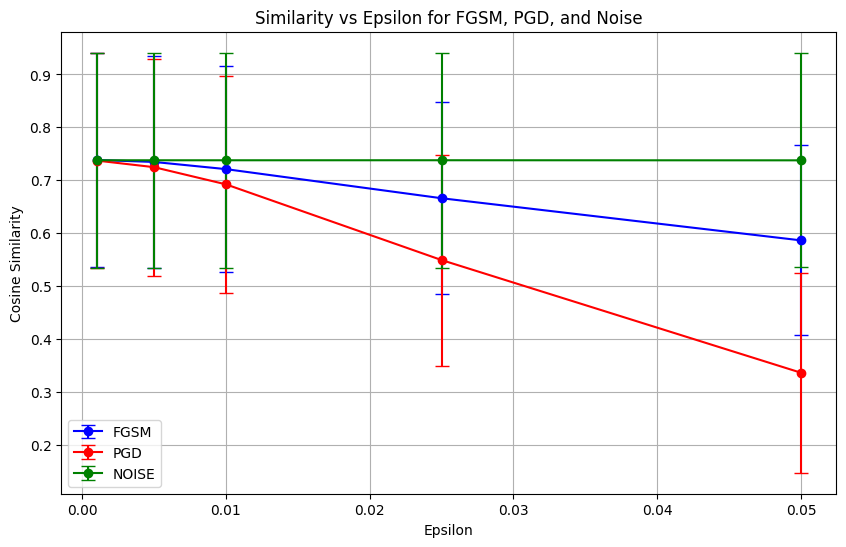

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for key, color in zip(results.keys(), ['blue', 'red', 'green']):
    means = [np.mean(results[key][eps]) for eps in epsilons]
    stds = [np.std(results[key][eps]) for eps in epsilons]
    plt.errorbar(epsilons, means, yerr=stds, label=key.upper(), fmt='-o', capsize=5, color=color)

plt.xlabel("Epsilon")
plt.ylabel("Cosine Similarity")
plt.title("Similarity vs Epsilon for FGSM, PGD, and Noise")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

threshold = 0.7  # Cosine similarity cutoff for a "successful" attack

# Create table with mean, std, and success rate
table_rows = []
for eps in epsilons:
    row = {'Epsilon': eps}
    for attack in ['fgsm', 'pgd', 'noise']:
        values = results[attack][eps]
        row[f'{attack.upper()} Mean'] = round(np.mean(values), 4)
        row[f'{attack.upper()} Std'] = round(np.std(values), 4)
        success_rate = np.mean(np.array(values) < threshold)
        row[f'{attack.upper()} Success Rate (<{threshold})'] = round(success_rate, 4)
    table_rows.append(row)

results_df = pd.DataFrame(table_rows)
results_df

,Epsilon,FGSM Mean,FGSM Std,FGSM Success Rate (<0.7),PGD Mean,PGD Std,PGD Success Rate (<0.7),NOISE Mean,NOISE Std,NOISE Success Rate (<0.7)
0,0.001,0.7385,0.2024,0.3070,0.7374,0.2029,0.3080,0.7379,0.2024,0.3075
1,0.005,0.7348,0.2000,0.3075,0.7249,0.2046,0.3280,0.7379,0.2024,0.3080
2,0.010,0.7212,0.1945,0.3290,0.6925,0.2050,0.3955,0.7379,0.2025,0.3080
3,0.025,0.6663,0.1815,0.4615,0.5496,0.1990,0.7650,0.7380,0.2027,0.3060
4,0.050,0.5867,0.1795,0.7115,0.3369,0.1887,0.9780,0.7378,0.2020,0.3055


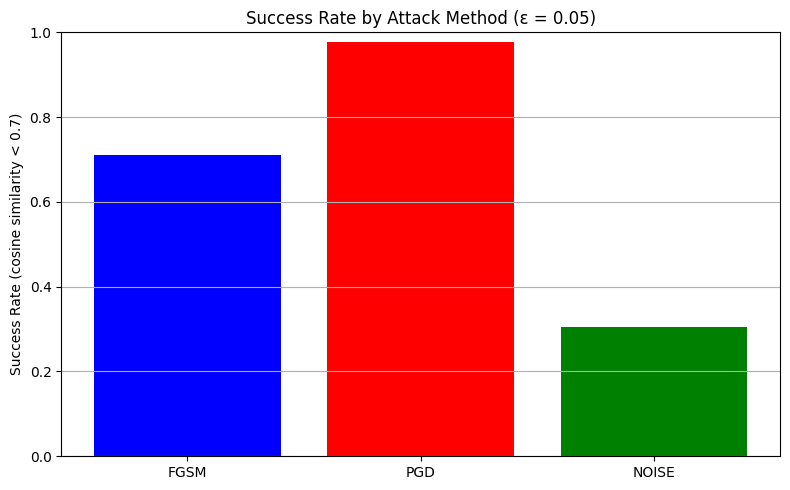

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define your cosine similarity threshold
threshold = 0.7
eps_target = 0.05  # Target epsilon value

# Compute success rates for each method at epsilon = 0.05
success_rates = {}
for attack in ['fgsm', 'pgd', 'noise']:
    values = results[attack][eps_target]
    success_rate = np.mean(np.array(values) < threshold)
    success_rates[attack.upper()] = success_rate

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(success_rates.keys(), success_rates.values(), color=['blue', 'red', 'green'])
plt.title(f"Success Rate by Attack Method (ε = {eps_target})")
plt.ylabel(f"Success Rate (cosine similarity < {threshold})")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
